In [308]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator
import numpy as np
import numpy as np
import pandas as pd
import statsmodels.api as sm
import numba as nb
from statsmodels.regression.mixed_linear_model import MixedLM
from statsmodels.formula.api import mixedlm
from tqdm import tqdm 
from aicsimageio import AICSImage


import statsmodels.api as sm
import statsmodels.formula.api as smf
def load_image(path):
    img = AICSImage(path)
    reshaped_img = img.data#.reshape(30, 1024, 1024)
    return int_to_float(reshaped_img)

def int_to_float(out):
    """
    Convert image data from integer to float format.

    Parameters:
    - out (np.ndarray): Input image data in integer format.

    Returns:
    - np.ndarray: Converted image data in float format.
    
    Note:
    If the input data type is 'uint16', the conversion is normalized to the range [0, 1]
    by dividing by ((2**16) - 1). If the input data type is 'uint8', the normalization
    is performed by dividing by ((2**8) - 1), resulting in the range [0, 1].
    """
    if out.dtype=='uint16':
        return out.astype(float)/((2**16)-1)
    elif out.dtype=='uint8':
        return out.astype(float)/((2**8)-1)
    


def fit_mixed_model(temp, mod, group):
    model = smf.mixedlm(mod, data=temp, groups=temp[group])
    result = model.fit()
    
    return result.summary()

def plot_boxplot_by_treatment(d, x_val, y_val, order, pairs, palette, ylim, ymin, pvalues=None):
    # Draw the boxplot with a semi-transparent fill (alpha=0.5) applied via boxprops.
    ax = sns.boxplot(
        data=d, 
        x=x_val, 
        y=y_val, 
        palette=palette, 
        order=order, 
        width=0.4, 
       # capsize=0.1, 
        linewidth=1,

        showfliers=False
    )

    ax.set_ylim(ymin,ylim)
    ax.set_xlim(-0.5, len(order)+5)
    # Overlay the stripplot
    sp = sns.stripplot(
        data=d, 
        x=x_val, 
        y=y_val, 
        dodge=False, 
        jitter=0.05, 
        alpha=1,  
        order=order, 
        color='black',
        #palette=palette,
        size=3
    )

    #plt.ylim(0, plt.ylim()[1])
    # Shift the stripplot points slightly to the left.
    shift = 0.4  # Adjust this value as needed
    for i, coll in enumerate(sp.collections):
        # if i == 0:
        #     shift = 0.4
        # elif i == 1:
        #     shift = 0.4
        # elif i == 2:
        #     shift = 0.4
            
        offsets = coll.get_offsets()
        # Subtract from the x-coordinate to move left
        offsets[:, 0] = offsets[:, 0] + shift
        coll.set_offsets(offsets)
    # Add statistical annotations
    annotator = Annotator(ax, pairs, data=d, x=x_val, y=y_val, order=order)
    annotator.set_pvalues(pvalues)
    annotator.configure(text_format='full', loc='outside', verbose=2, show_test_name=False)
    annotator.annotate()

    plt.xticks(rotation=0)
    plt.xlabel('')

    # Adjust the boxes so that the face remains semi-transparent while the edge is opaque.
    # Try iterating over both ax.artists and ax.patches.
    for patch in ax.patches:
        # Get the current facecolor (an RGBA tuple)
        fc = patch.get_facecolor()
        # Set the facecolor to have your desired alpha (e.g., 0.5)
        patch.set_facecolor((fc[0], fc[1], fc[2], 0.5))
        # Set the edgecolor to the same RGB but fully opaque (alpha=1)
        #patch.set_edgecolor((fc[0], fc[1], fc[2], 1.0))
        patch.set_linewidth(1)

    return ax
#plt.savefig('../../paper/main_plots/tmrm_choline_boxplot.png', dpi=300, bbox_inches='tight')


In [309]:
# scale and combine data
paths = ['../../mitohealth/neuronbatch11082023_mitohealth_out_quant_continuous.csv', # this batch has only 2 DGAT replicates
        '../../mitohealth/neuronbatch11222023_mitohealth_out_quant_continuous.csv',
        '../../mitohealth/neuronbatch11152023_mitohealth_out_quant_continuous.csv']

o = []
x=0
for i in paths:
    out_parent = i
    df = pd.read_csv(out_parent)
    
    df_sele = df[((df['line']=='E3') | (df['line']=='G2') | (df['line']=='Y622')) & (df['treatment']=='vehicle')]

    # Find the minimum number of rows per 'line'
    min_rows_per_line = df_sele.groupby('line').size().min()

    # Sample uniformly without replacement
    sampled_df = df_sele.groupby('line').apply(lambda x: x.sample(n=min_rows_per_line, random_state=1)).reset_index(drop=True)

    sampled_df['scaled']  = (sampled_df['mitohealth'] - np.mean(sampled_df['mitohealth']))/np.std(sampled_df['mitohealth'])
    
    sampled_df['batch'] = str(x)
    
    o.append(sampled_df)
    x+=1

/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_16460/3084960591.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df_sele.groupby('line').apply(lambda x: x.sample(n=min_rows_per_line, random_state=1)).reset_index(drop=True)
/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_16460/3084960591.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df_sele.groupby(

In [310]:
# concat data

data = pd.concat(o)#[:2])
data['well'] = [i.split('-')[0] for i in data['file']]
data['well'] = data['batch'].str.cat(data['well'], sep=' ')

data.index = range(data.shape[0])

In [311]:
# get average scaled data
mean_scaled = data.groupby(['well', 'line'])['scaled'].mean().reset_index()

In [312]:
# do stats
outY = fit_mixed_model(data[data['line']!='G2'], "scaled ~ line", 'well')
outG = fit_mixed_model(data[data['line']!='Y622'], "scaled ~ line", 'well')


In [313]:
# get rep images

temp = data[data['batch']=='1']

# For each treatment, find the row whose 'scaled' value is closest to the group mean
closest_to_mean = temp.groupby('line').apply(
    lambda group: group.loc[(group['mitohealth'] - group['mitohealth'].mean()).abs().idxmin()]
).reset_index(drop=True)
closest_to_mean

/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_16460/4158401923.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  closest_to_mean = temp.groupby('line').apply(


,Unnamed: 0,dapi,neun,mitohealth,size,file_ID,mask_ID,file,line,treatment,scaled,batch,well
0,389,0.130158,0.020723,0.056967,557.0,0,390,B02-1.czi,E3,vehicle,-0.552985,1,1 B02
1,56,0.034952,0.098433,0.079901,3313.0,50,57,G02-1.czi,G2,vehicle,0.181611,1,1 G02
2,4,0.055815,0.091782,0.085777,3750.0,20,5,D03-1.czi,Y622,vehicle,0.369838,1,1 D03


In [113]:
temp[temp['line']=='E3'].groupby('file')['mitohealth'].mean()

file
B02-1.czi    0.068137
B03-1.czi    0.053251
C02-1.czi    0.038628
C03-1.czi    0.060914
Name: mitohealth, dtype: float64

In [245]:
temp[temp['line']=='G2'].groupby('file')['mitohealth'].mean()

file
F03-1.czi    0.086930
F03-2.czi    0.080508
G02-1.czi    0.069931
G03-1.czi    0.082743
Name: mitohealth, dtype: float64

In [314]:
# # load image for physical pixel size
# import matplotlib.patches as patches

# img = AICSImage('../../../../Downloads/D03-1.czi')

# img.data

In [315]:
# compute the pvalues
y622_pval = float(outY.tables[1][['P>|z|']].loc['line[T.Y622]'].values[0])
g2_pval = float(outG.tables[1][['P>|z|']].loc['line[T.G2]'].values[0])
pvalues = [y622_pval, g2_pval]

In [53]:
square_size = 500

# Calculate the starting and ending indices for the middle square
start = (1000 - square_size) // 2  # both for rows and columns
end = start + square_size

/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/djuna/Library/Python/3.9/lib/python/site-packages/statannotations/Annotator.py:825: UserWarning: Annotator

E3 vs. Y622: Custom statistical test, P_val:2.000e-03
E3 vs. G2: Custom statistical test, P_val:4.000e-03


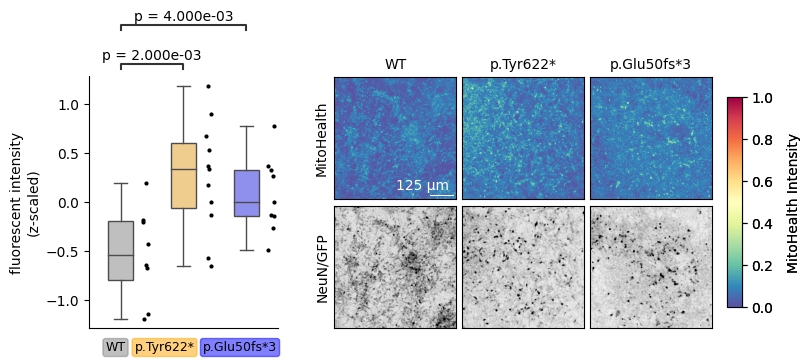

In [344]:
# Create a new figure with a gridspec with 1 row and 2 columns.
fig = plt.figure(figsize=(7.5, 3))
gs = fig.add_gridspec(1, 2, width_ratios=[0.6, 1.2])  # adjust ratios as needed

# ------------------
# Left: Boxplot panel
# ------------------
ax_box = fig.add_subplot(gs[0])
# (Option 1) If your function does not accept an ax parameter, you can set the current axes:
plt.sca(ax_box)

ax1 = plot_boxplot_by_treatment(mean_scaled, 'line', 'scaled', order = ['E3', 'Y622', 'G2'], pairs = [('E3', 'Y622'), ('E3', 'G2')],palette={'E3': 'grey', 'Y622': 'orange', 'G2': 'blue'}, 
                                ylim = np.max(mean_scaled['scaled']+.1), ymin = np.min(mean_scaled['scaled']-.1), pvalues=pvalues)

ax1.set_xticks([])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_ylabel('fluorescent intensity\n(z-scaled)')

ax1.text(-0.08, -0.05, "WT", ha='center', va='top', transform=ax1.get_xaxis_transform(),
         bbox=dict(boxstyle="round,pad=0.2", fc="grey", ec="grey", alpha=0.5), fontsize=9)
ax1.text(0.7, -0.05, "p.Tyr622*", ha='center', va='top', transform=ax1.get_xaxis_transform(),
         bbox=dict(boxstyle="round,pad=0.2", fc="orange", ec="orange", alpha=0.5), fontsize=9)
ax1.text(1.9, -0.05, "p.Glu50fs*3", ha='center', va='top', transform=ax1.get_xaxis_transform(),
         bbox=dict(boxstyle="round,pad=0.2", fc="blue", ec="blue", alpha=0.5), fontsize=9)


ax_box.spines['top'].set_visible(False)
ax_box.spines['right'].set_visible(False)
#ax_box.set_ylim(0, 0.35)

# Create a nested gridspec for the right panel (2 rows x 2 columns)
gs_right = gs[1].subgridspec(2, 3, wspace=0.05, hspace=0.05)

# ------------------
# COLUMN 1
# ------------------

# Top left image
ax_img1 = fig.add_subplot(gs_right[1, 0])

x = load_image('../../mitohealth/neuronbatch11222023_mitohealth/B02-1.czi')
f = np.mean(x[0],axis=1)
# Clip image at 95th percentile to 1
f = np.transpose(f, (1, 2, 0)) 

percentile_95 = np.percentile(f[:,:,1], 99)
f[:,:,1]= np.clip(f[:,:,1], None, percentile_95) / percentile_95


ax_img1.imshow(f[:,:,1], vmin=0, vmax=1, cmap='gray_r')
ax_img1.set_xticks([])
ax_img1.set_yticks([])
ax_img1.set_ylabel('NeuN/GFP')

f = np.max(x[0],axis=1)
f = np.transpose(f, (1, 2, 0)) 

ax_img2 = fig.add_subplot(gs_right[0, 0])
ax_img2.imshow(f[:,:,2], vmin=0, vmax=1, cmap='Spectral_r')
ax_img2.set_xticks([])
ax_img2.set_yticks([])
ax_img2.set_ylabel('MitoHealth')
ax_img2.set_title('WT', fontsize=10)


# ------------------
# COLUMN 2
# ------------------

# Top left image
ax_img3 = fig.add_subplot(gs_right[1, 1])

x = load_image('../../mitohealth/neuronbatch11222023_mitohealth/D03-1.czi')
f = np.mean(x[0],axis=1)
# Clip image at 95th percentile to 1
f = np.transpose(f, (1, 2, 0)) 
percentile_95 = np.percentile(f[:,:,1], 99)
f[:,:,1]= np.clip(f[:,:,1], None, percentile_95) / percentile_95


ax_img3.imshow(f[:,:,1], vmin=0, vmax=1, cmap='gray_r')
ax_img3.set_xticks([])
ax_img3.set_yticks([])

f = np.max(x[0],axis=1)
f = np.transpose(f, (1, 2, 0)) 

ax_img4 = fig.add_subplot(gs_right[0, 1])
ax_img4.imshow(f[:,:,2], vmin=0, vmax=1, cmap='Spectral_r')
ax_img4.set_xticks([])
ax_img4.set_yticks([])
ax_img4.set_title('p.Tyr622*', fontsize=10)


# Optionally add a colorbar to the right of the image panel
norm = plt.Normalize(vmin=0, vmax=1)
sm = plt.cm.ScalarMappable(cmap='Spectral_r', norm=norm)
sm.set_array([])
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label('MitoHealth Intensity', labelpad=10)

# ------------------
# COLUMN 3
# ------------------

# Top left image
ax_img4 = fig.add_subplot(gs_right[1, 2])

x = load_image('../../mitohealth/neuronbatch11222023_mitohealth/F03-2.czi')
f = np.mean(x[0],axis=1)
# Clip image at 95th percentile to 1
f = np.transpose(f, (1, 2, 0)) 
percentile_95 = np.percentile(f[:,:,1], 99)
f[:,:,1]= np.clip(f[:,:,1], None, percentile_95) / percentile_95


ax_img4.imshow(f[:,:,1], vmin=0, vmax=1, cmap='gray_r')
ax_img4.set_xticks([])
ax_img4.set_yticks([])

f = np.max(x[0],axis=1)
f = np.transpose(f, (1, 2, 0)) 

ax_img5 = fig.add_subplot(gs_right[0, 2])
ax_img5.imshow(f[:,:,2], vmin=0, vmax=1, cmap='Spectral_r')
ax_img5.set_xticks([])
ax_img5.set_yticks([])
ax_img5.set_title('p.Glu50fs*3', fontsize=10)


# Optionally add a colorbar to the right of the image panel
norm = plt.Normalize(vmin=0, vmax=1)
sm = plt.cm.ScalarMappable(cmap='Spectral_r', norm=norm)
sm.set_array([])
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label('MitoHealth Intensity', labelpad=10)


# ------------------
# Final adjustments and save
# ------------------

##### SCALE BAR
# plt.subplots_adjust(left=0.07, right=0.9, top=0.92, bottom=0.08)
import matplotlib.patches as patches

# Assume the image dimensions in out_fppc[0] (height, width)
img_height, img_width = f[:,:,2].shape
bar_length = 200    # scale bar length in pixels (adjust as needed)
bar_height = 10     # thickness of the scale bar in pixels

# Position the scale bar in the lower right corner with some margin
margin = 20
x_start = img_width - bar_length - margin
y_start = img_height - margin

# Create a white rectangle for the scale bar
scale_bar = patches.Rectangle((x_start, y_start - bar_height), bar_length, bar_height, 
                               linewidth=0, edgecolor=None, facecolor='white')
ax_img2.add_patch(scale_bar)

img = AICSImage('../../mitohealth/neuronbatch11222023_mitohealth/F03-2.czi')
# Add a text label above the scale bar (centered)
ax_img2.text(x_start-60, y_start-150, f'{bar_length * img.physical_pixel_sizes[1]:.0f} μm', 
                color='white', ha='center', va='top', fontsize=10)


plt.subplots_adjust(left=0.07, right=0.9, top=0.92, bottom=0.08)

plt.savefig('../../paper/extended_plots/mitohealth_y_g.png', dpi=300, bbox_inches='tight')


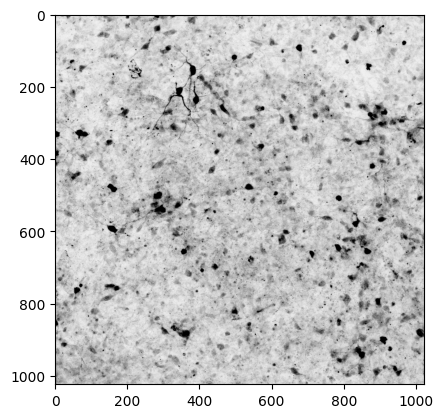

In [279]:

x = load_image('../../../../Downloads/F03-1.czi')
f = np.mean(x[0],axis=1)
# Clip image at 95th percentile to 1
f = np.transpose(f, (1, 2, 0)) 
percentile_95 = np.percentile(f[:,:,1], 99)
f[:,:,1]= np.clip(f[:,:,1], None, percentile_95) / percentile_95


plt.imshow(f[:,:,1], vmin=0, vmax=1, cmap='gray_r')

/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/djuna/Library/Python/3.9/lib/python/site-packages/statannotations/Annotator.py:825: UserWarning: Annotator

E3 vs. Y622: Custom statistical test, P_val:2.000e-03
E3 vs. G2: Custom statistical test, P_val:4.000e-03


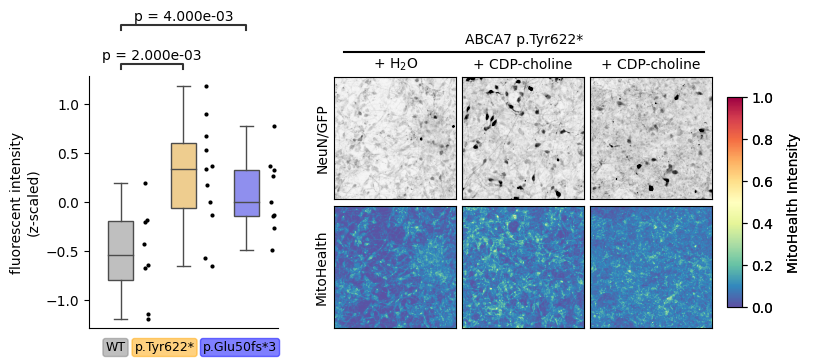

In [78]:
# Create a new figure with a gridspec with 1 row and 2 columns.
fig = plt.figure(figsize=(7.5, 3))
gs = fig.add_gridspec(1, 2, width_ratios=[0.6, 1.2])  # adjust ratios as needed

# ------------------
# Left: Boxplot panel
# ------------------
ax_box = fig.add_subplot(gs[0])
# (Option 1) If your function does not accept an ax parameter, you can set the current axes:
plt.sca(ax_box)

ax1 = plot_boxplot_by_treatment(mean_scaled, 'line', 'scaled', order = ['E3', 'Y622', 'G2'], pairs = [('E3', 'Y622'), ('E3', 'G2')],palette={'E3': 'grey', 'Y622': 'orange', 'G2': 'blue'}, 
                                ylim = np.max(mean_scaled['scaled']+.1), ymin = np.min(mean_scaled['scaled']-.1), pvalues=pvalues)

ax1.set_xticks([])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_ylabel('fluorescent intensity\n(z-scaled)')

ax1.text(-0.08, -0.05, "WT", ha='center', va='top', transform=ax1.get_xaxis_transform(),
         bbox=dict(boxstyle="round,pad=0.2", fc="grey", ec="grey", alpha=0.5), fontsize=9)
ax1.text(0.7, -0.05, "p.Tyr622*", ha='center', va='top', transform=ax1.get_xaxis_transform(),
         bbox=dict(boxstyle="round,pad=0.2", fc="orange", ec="orange", alpha=0.5), fontsize=9)
ax1.text(1.9, -0.05, "p.Glu50fs*3", ha='center', va='top', transform=ax1.get_xaxis_transform(),
         bbox=dict(boxstyle="round,pad=0.2", fc="blue", ec="blue", alpha=0.5), fontsize=9)


ax_box.spines['top'].set_visible(False)
ax_box.spines['right'].set_visible(False)
#ax_box.set_ylim(0, 0.35)

# Create a nested gridspec for the right panel (2 rows x 2 columns)
gs_right = gs[1].subgridspec(2, 3, wspace=0.05, hspace=0.05)

# ------------------
# COLUMN 1
# ------------------

# Top left image
ax_img1 = fig.add_subplot(gs_right[0, 0])

x = load_image('../../../../Downloads/B02-1.czi')
f = np.max(x[0],axis=1)
f = np.transpose(f, (1, 2, 0)) 

ax_img1.imshow(f[:,:,1][start:end,start:end], vmin=0, vmax=0.2, cmap='gray_r')
ax_img1.set_title('+ H$_2$O', fontsize=10)
ax_img1.set_xticks([])
ax_img1.set_yticks([])
ax_img1.set_ylabel('NeuN/GFP')

ax_img2 = fig.add_subplot(gs_right[1, 0])
ax_img2.imshow(f[:,:,2][start:end,start:end], vmin=0, vmax=1, cmap='Spectral_r')
ax_img2.set_xticks([])
ax_img2.set_yticks([])
ax_img2.set_ylabel('MitoHealth')


# ------------------
# COLUMN 2
# ------------------

# Top left image
ax_img3 = fig.add_subplot(gs_right[0, 1])

x = load_image('../../../../Downloads/D03-1.czi')
f = np.max(x[0],axis=1)
f = np.transpose(f, (1, 2, 0)) 

ax_img3.imshow(f[:,:,1][start:end,start:end], vmin=0, vmax=0.2, cmap='gray_r')
ax_img3.set_title('+ CDP-choline', fontsize=10)
ax_img3.set_xticks([])
ax_img3.set_yticks([])

ax_img4 = fig.add_subplot(gs_right[1, 1])
ax_img4.imshow(f[:,:,2][start:end,start:end], vmin=0, vmax=1, cmap='Spectral_r')
ax_img4.set_xticks([])
ax_img4.set_yticks([])


# Optionally add a colorbar to the right of the image panel
norm = plt.Normalize(vmin=0, vmax=1)
sm = plt.cm.ScalarMappable(cmap='Spectral_r', norm=norm)
sm.set_array([])
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label('MitoHealth Intensity', labelpad=10)

# ------------------
# COLUMN 3
# ------------------

# Top left image
ax_img4 = fig.add_subplot(gs_right[0, 2])

x = load_image('../../../../Downloads/G02-1.czi')
f = np.max(x[0],axis=1)
f = np.transpose(f, (1, 2, 0)) 

ax_img4.imshow(f[:,:,1][start:end,start:end], vmin=0, vmax=0.2, cmap='gray_r')
ax_img4.set_title('+ CDP-choline', fontsize=10)
ax_img4.set_xticks([])
ax_img4.set_yticks([])

ax_img5 = fig.add_subplot(gs_right[1, 2])
ax_img5.imshow(f[:,:,2][start:end,start:end], vmin=0, vmax=1, cmap='Spectral_r')
ax_img5.set_xticks([])
ax_img5.set_yticks([])


# Optionally add a colorbar to the right of the image panel
norm = plt.Normalize(vmin=0, vmax=1)
sm = plt.cm.ScalarMappable(cmap='Spectral_r', norm=norm)
sm.set_array([])
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label('MitoHealth Intensity', labelpad=10)


# ------------------
# Final adjustments and save
# ------------------

# Add single bar and title spanning both columns
fig.text(0.65, 1.03, 'ABCA7 p.Tyr622*', horizontalalignment='center', fontsize=10)

# Add vertical bar above spanning both columns
bar_width = 5
bar_y = 1
fig.add_artist(plt.Line2D([0.41, 0.89], [bar_y, bar_y], color='black', transform=fig.transFigure))


##### SCALE BAR


# Assume the image dimensions in out_fppc[0] (height, width)
img_height, img_width = f[:,:,1].shape
bar_length = 200    # scale bar length in pixels (adjust as needed)
bar_height = 20     # thickness of the scale bar in pixels

# Position the scale bar in the lower right corner with some margin
margin = 20
x_start = img_width - bar_length - margin
y_start = img_height - margin

# Create a white rectangle for the scale bar
scale_bar = patches.Rectangle((x_start, y_start - bar_height), bar_length, bar_height, 
                               linewidth=0, edgecolor=None, facecolor='white')
ax_img4.add_patch(scale_bar)

# Add a text label above the scale bar (centered)
ax_img4.text(x_start, y_start-150, f'{bar_length * img.physical_pixel_sizes[1]:.0f} μm', 
                color='white', ha='center', va='top', fontsize=10)

plt.subplots_adjust(left=0.07, right=0.9, top=0.92, bottom=0.08)

#plt.savefig('../../paper/extended_plots/mitohealth_treatment.png', dpi=300, bbox_inches='tight')


/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/djuna/Library/Python/3.9/lib/python/site-packages/statannotations/Annotator.py:825: UserWarning: Annotator

E3 vs. Y622: Custom statistical test, P_val:2.000e-03
E3 vs. G2: Custom statistical test, P_val:4.000e-03


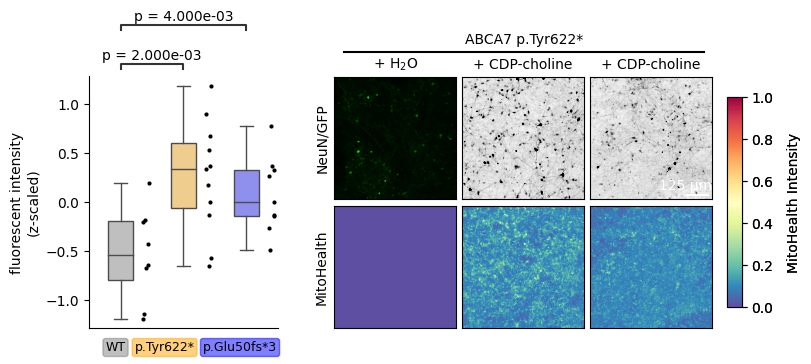

In [44]:
# Create a new figure with a gridspec with 1 row and 2 columns.
fig = plt.figure(figsize=(7.5, 3))
gs = fig.add_gridspec(1, 2, width_ratios=[0.6, 1.2])  # adjust ratios as needed

# ------------------
# Left: Boxplot panel
# ------------------
ax_box = fig.add_subplot(gs[0])
# (Option 1) If your function does not accept an ax parameter, you can set the current axes:
plt.sca(ax_box)

ax1 = plot_boxplot_by_treatment(mean_scaled, 'line', 'scaled', order = ['E3', 'Y622', 'G2'], pairs = [('E3', 'Y622'), ('E3', 'G2')],palette={'E3': 'grey', 'Y622': 'orange', 'G2': 'blue'}, 
                                ylim = np.max(mean_scaled['scaled']+.1), ymin = np.min(mean_scaled['scaled']-.1), pvalues=pvalues)

ax1.set_xticks([])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_ylabel('fluorescent intensity\n(z-scaled)')

ax1.text(-0.08, -0.05, "WT", ha='center', va='top', transform=ax1.get_xaxis_transform(),
         bbox=dict(boxstyle="round,pad=0.2", fc="grey", ec="grey", alpha=0.5), fontsize=9)
ax1.text(0.7, -0.05, "p.Tyr622*", ha='center', va='top', transform=ax1.get_xaxis_transform(),
         bbox=dict(boxstyle="round,pad=0.2", fc="orange", ec="orange", alpha=0.5), fontsize=9)
ax1.text(1.9, -0.05, "p.Glu50fs*3", ha='center', va='top', transform=ax1.get_xaxis_transform(),
         bbox=dict(boxstyle="round,pad=0.2", fc="blue", ec="blue", alpha=0.5), fontsize=9)


ax_box.spines['top'].set_visible(False)
ax_box.spines['right'].set_visible(False)
#ax_box.set_ylim(0, 0.35)

# Create a nested gridspec for the right panel (2 rows x 2 columns)
gs_right = gs[1].subgridspec(2, 3, wspace=0.05, hspace=0.05)

# ------------------
# COLUMN 1
# ------------------

# Top left image
ax_img1 = fig.add_subplot(gs_right[0, 0])

x = load_image('../../../../Downloads/B03-2.czi')
f = np.max(x[0],axis=1)
f[0] = 0
f[2] = 0
f = np.transpose(f, (1, 2, 0)) 

ax_img1.imshow(f, vmin=0, vmax=0.2)
ax_img1.set_title('+ H$_2$O', fontsize=10)
ax_img1.set_xticks([])
ax_img1.set_yticks([])
ax_img1.set_ylabel('NeuN/GFP')

ax_img2 = fig.add_subplot(gs_right[1, 0])
ax_img2.imshow(f[:,:,2], vmin=0, vmax=1, cmap='Spectral_r')
ax_img2.set_xticks([])
ax_img2.set_yticks([])
ax_img2.set_ylabel('MitoHealth')


# ------------------
# COLUMN 2
# ------------------

# Top left image
ax_img3 = fig.add_subplot(gs_right[0, 1])

x = load_image('../../../../Downloads/E02-1.czi')
f = np.max(x[0],axis=1)
f = np.transpose(f, (1, 2, 0)) 

ax_img3.imshow(f[:,:,1], vmin=0, vmax=0.2, cmap='gray_r')
ax_img3.set_title('+ CDP-choline', fontsize=10)
ax_img3.set_xticks([])
ax_img3.set_yticks([])

ax_img4 = fig.add_subplot(gs_right[1, 1])
ax_img4.imshow(f[:,:,2], vmin=0, vmax=1, cmap='Spectral_r')
ax_img4.set_xticks([])
ax_img4.set_yticks([])


# Optionally add a colorbar to the right of the image panel
norm = plt.Normalize(vmin=0, vmax=1)
sm = plt.cm.ScalarMappable(cmap='Spectral_r', norm=norm)
sm.set_array([])
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label('MitoHealth Intensity', labelpad=10)

# ------------------
# COLUMN 3
# ------------------

# Top left image
ax_img4 = fig.add_subplot(gs_right[0, 2])

x = load_image('../../../../Downloads/G03-1.czi')
f = np.max(x[0],axis=1)
f = np.transpose(f, (1, 2, 0)) 

ax_img4.imshow(f[:,:,1], vmin=0, vmax=0.2, cmap='gray_r')
ax_img4.set_title('+ CDP-choline', fontsize=10)
ax_img4.set_xticks([])
ax_img4.set_yticks([])

ax_img5 = fig.add_subplot(gs_right[1, 2])
ax_img5.imshow(f[:,:,2], vmin=0, vmax=1, cmap='Spectral_r')
ax_img5.set_xticks([])
ax_img5.set_yticks([])


# Optionally add a colorbar to the right of the image panel
norm = plt.Normalize(vmin=0, vmax=1)
sm = plt.cm.ScalarMappable(cmap='Spectral_r', norm=norm)
sm.set_array([])
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label('MitoHealth Intensity', labelpad=10)


# ------------------
# Final adjustments and save
# ------------------

# Add single bar and title spanning both columns
fig.text(0.65, 1.03, 'ABCA7 p.Tyr622*', horizontalalignment='center', fontsize=10)

# Add vertical bar above spanning both columns
bar_width = 5
bar_y = 1
fig.add_artist(plt.Line2D([0.41, 0.89], [bar_y, bar_y], color='black', transform=fig.transFigure))


##### SCALE BAR


# Assume the image dimensions in out_fppc[0] (height, width)
img_height, img_width = f[:,:,1].shape
bar_length = 200    # scale bar length in pixels (adjust as needed)
bar_height = 20     # thickness of the scale bar in pixels

# Position the scale bar in the lower right corner with some margin
margin = 20
x_start = img_width - bar_length - margin
y_start = img_height - margin

# Create a white rectangle for the scale bar
scale_bar = patches.Rectangle((x_start, y_start - bar_height), bar_length, bar_height, 
                               linewidth=0, edgecolor=None, facecolor='white')
ax_img4.add_patch(scale_bar)

# Add a text label above the scale bar (centered)
ax_img4.text(x_start, y_start-150, f'{bar_length * img.physical_pixel_sizes[1]:.0f} μm', 
                color='white', ha='center', va='top', fontsize=10)

plt.subplots_adjust(left=0.07, right=0.9, top=0.92, bottom=0.08)

#plt.savefig('../../paper/extended_plots/mitohealth_treatment.png', dpi=300, bbox_inches='tight')


E3 vs. Y622: Custom statistical test, P_val:2.000e-03
E3 vs. G2: Custom statistical test, P_val:4.000e-03


/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/djuna/Library/Python/3.9/lib/python/site-packages/statannotations/Annotator.py:825: UserWarning: Annotator

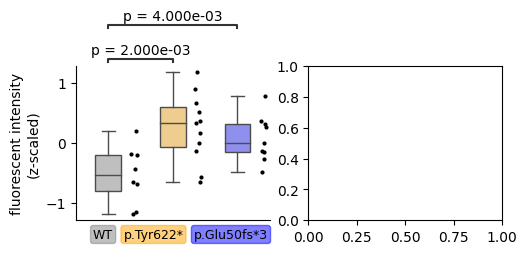

In [118]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5.5, 2))

plt.sca(ax1)


ax1 = plot_boxplot_by_treatment(mean_scaled, 'line', 'scaled', order = ['E3', 'Y622', 'G2'], pairs = [('E3', 'Y622'), ('E3', 'G2')],palette={'E3': 'grey', 'Y622': 'orange', 'G2': 'blue'}, 
                                ylim = np.max(mean_scaled['scaled']+.1), ymin = np.min(mean_scaled['scaled']-.1), pvalues=pvalues)

ax1.set_xticks([])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_ylabel('fluorescent intensity\n(z-scaled)')

ax1.text(-0.08, -0.05, "WT", ha='center', va='top', transform=ax1.get_xaxis_transform(),
         bbox=dict(boxstyle="round,pad=0.2", fc="grey", ec="grey", alpha=0.5), fontsize=9)
ax1.text(0.7, -0.05, "p.Tyr622*", ha='center', va='top', transform=ax1.get_xaxis_transform(),
         bbox=dict(boxstyle="round,pad=0.2", fc="orange", ec="orange", alpha=0.5), fontsize=9)
ax1.text(1.9, -0.05, "p.Glu50fs*3", ha='center', va='top', transform=ax1.get_xaxis_transform(),
         bbox=dict(boxstyle="round,pad=0.2", fc="blue", ec="blue", alpha=0.5), fontsize=9)

plt.sca(ax2)

In [35]:
def load_image(path):
    img = AICSImage(path)
    reshaped_img = img.data.reshape(30, 1024, 1024)
    return int_to_float(reshaped_img)

def int_to_float(out):
    """
    Convert image data from integer to float format.

    Parameters:
    - out (np.ndarray): Input image data in integer format.

    Returns:
    - np.ndarray: Converted image data in float format.
    
    Note:
    If the input data type is 'uint16', the conversion is normalized to the range [0, 1]
    by dividing by ((2**16) - 1). If the input data type is 'uint8', the normalization
    is performed by dividing by ((2**8) - 1), resulting in the range [0, 1].
    """
    if out.dtype=='uint16':
        return out.astype(float)/((2**16)-1)
    elif out.dtype=='uint8':
        return out.astype(float)/((2**8)-1)
    


E3 vs Y622 scaled across two batches:


'0.002'

In [38]:

print('E3 vs G2 scaled across two batches:')
print(fit_mixed_model(data[data['line']!='Y622'], "scaled ~ line", 'well'))

E3 vs G2 scaled across two batches:
         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: scaled    
No. Observations: 6000    Method:             REML      
No. Groups:       17      Scale:              0.7002    
Min. group size:  137     Log-Likelihood:     -7483.3839
Max. group size:  729     Converged:          Yes       
Mean group size:  352.9                                 
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept     -0.528    0.153 -3.452 0.001 -0.828 -0.228
line[T.G2]     0.612    0.210  2.909 0.004  0.199  1.024
Group Var      0.185    0.082                           

